# STQD6324: Assignment 2

## Nurul Syafiqah binti Hasbullah Hafidz (P146224)

### AIRLINE ON TIME PERFORMANCE

#### INTRODUCTION

The Airline On-Time Performance dataset was obtained from kaggle - Data Expo 2009: Airline On Time Data (https://www.kaggle.com/datasets/wenxingdi/data-expo-2009-airline-on-time-data/data?select=1999.csv). The dataset from 2009 ASA Statistical Computing and Graphics Data Expo consisted of flight arrival and departure details for all commercial flights. This dataset includes information on over 120 million on individual flight that represents as the most extensive public transportation datasets available.

This airline performance dataset comprises multiple yearly files that covering USA flight records from 1987 to 2008. This analysis will specifically focuses on the data from 2005. Each observation in the dataset includes detailed per-flight information which captures both timing and operational aspects such as delays, cancellations, diversions and the contributing factors along with airline, airport and aircraft details.

#### PROBLEM STATEMENT

Flight delays and cancellations are persistent issues in the aviation industry. These disruptions lead to economic losses, reduced customer satisfaction and systemic inefficiencies. Passengers often lack of information needed to predict or avoid travel disruptions especially during bad whether and when airlines face challenges in managing operations and maintaining sevice realiability.

This analysis aims to understand the factors that contribute to delays, assess their impact over time and explore opportunities for delay prediction and mitigation.

#### OBJECTIVES

1) Delay Patterns
- To analyse times of day (morning/afternoon/evening) have the lowest average delays.
- To examine which days of the week show better on-time performance.
- To investigate which months or seasons are flights most likely to be on time.

2) Delay Factors
- To identify and rank the top 3-5 factors contributing to flight delays (based on the delay categories provided in the dataset).
- To quantify the impact of each factor (in minutes of delay and percentage of total delays).

3) Cancellation Analysis
- To identify the primary reasons for flight cancellations as categorized in the dataset.
- To determine if cancellations correlate with specific airlines, airports, or time periods.

4) Problematic Routes
- To identify specific routes (origin-destination pairs), carriers or flight numbers that show consistently poor performance.
- To analyse the reasons these particular flights are prone to delays or cancellations.

In [1]:
#Load library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
import seaborn as sns

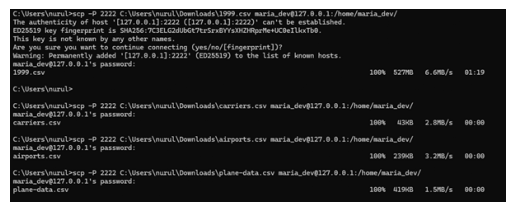

In [2]:
img = mpimg.imread('C:/Users/nurul/OneDrive/Desktop/MASTER/SEM 2/STQD6324 - Data Mgt/2. ASSIGNMENT/import ambari.png',)

plt.imshow(img)
plt.axis('off')
plt.show()

The image above shows the process of importing the csv file that are downloaded from Kaggle into HDFS Ambari

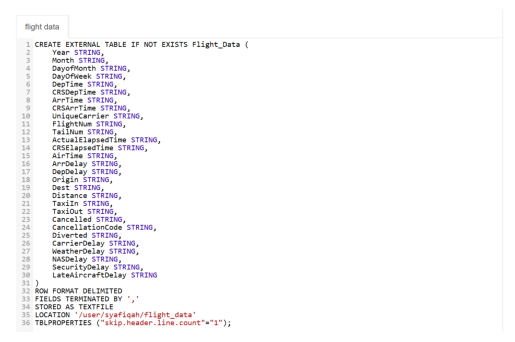

In [3]:
img2 = mpimg.imread('C:/Users/nurul/OneDrive/Desktop/MASTER/SEM 2/STQD6324 - Data Mgt/2. ASSIGNMENT/hive.png',)

plt.imshow(img2)
plt.axis('off')
plt.show()

The image above shows the process of creating the databases in Hive

#### RESULTS AND DISCUSSION

In [3]:
#Install impala module
!pip install impyla

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for thrift: filename=thrift-0.16.0-py3-none-any.whl size=194370 sha256=0bb35c055f84aad8d4e8657807ba0e43dfb17923788831a060a6c6073588e97a
  Stored in directory: c:\users\nurul\appdata\local\pip\cache\wheels\d1\cb\b5\152b7db4713756f7d1b4ca1a269a8c9f50fa04d0373d726a75
  Created wheel for pure-sasl: filename=pure_sasl-0.6.2-py3-none-any.whl size=11438 sha256=d3d2f795011852e6e8d8e1e6ad7cf735c509dde72a1f6f057ed810fd92e8f7ca
  Stored in directory: c:\users\nurul\appdata\local\pip\cache\wheels\5d\bf\32\7369b8b034de66e1c91d3ac3dafbff77ae3c97b9c5c97ea1b2
Successfully built thrift pure-sasl


In [3]:
#Import packages
from impala.dbapi import connect
import warnings

warnings.filterwarnings("ignore")

conn = connect(
    host='127.0.0.1',
    port=10000,
    user='maria_dev',
    database='default',
    auth_mechanism='PLAIN'
)
cursor = conn.cursor()
cursor.execute('SHOW TABLES')  #show all tables available in default 
print(cursor.fetchall())

[('airports',), ('carriers',), ('flight_data',), ('flight_data_2005',), ('movie_names',), ('planes',), ('ratings',)]


There are four database that will be used which are '**flight_data_2005**', '**airports**', '**carriers**' and '**planes**'

##### 1. DELAY PATTERNS

###### a) What times of day (morning/afternoon/evening) have the lowest average delays? 

In [5]:
#SQL query to read the data in hive
query = 'SELECT deptime, arrdelay, depdelay, dayofweek, month FROM flight_data_2005 WHERE cancelled = 0 AND deptime IS NOT NULL AND depdelay IS NOT NULL' 
flightdata = pd.read_sql(query, conn)
flightdata.head()

,deptime,arrdelay,depdelay,dayofweek,month
0,1603,-18,-2,5,1
1,1559,-23,-6,6,1
2,1603,-24,-7,7,1
3,1556,-33,-9,1,1
4,1934,3,34,7,1


In [6]:
#Information about the DataFrame
print(flightdata.info()) 

#Summary statistics
print(flightdata.describe()) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7006862 entries, 0 to 7006861
Data columns (total 5 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   deptime    object
 1   arrdelay   object
 2   depdelay   object
 3   dayofweek  object
 4   month      object
dtypes: object(5)
memory usage: 267.3+ MB
None
        deptime arrdelay depdelay dayofweek    month
count   7006862  7006862  7006862   7006862  7006862
unique     1584     1137     1202         7       12
top         700       -5        0         5        8
freq      24180   292070  1267423   1033633   617451


In [7]:
#Ensure DepTime is numeric
flightdata['deptime'] = pd.to_numeric(flightdata['deptime'], errors='coerce')
#Remove missing or invalid values
flightdata_new = flightdata.dropna(subset=['deptime'])

#Extract hour from DepTime
flightdata_new['dephour'] = flightdata_new['deptime'].astype(int) // 100

#Categorize by time of day
def classify_period(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

flightdata_new['period'] = flightdata_new['dephour'].apply(classify_period)
flightdata_new.head()

,deptime,arrdelay,depdelay,dayofweek,month,dephour,period
0,1603,-18,-2,5,1,16,Afternoon
1,1559,-23,-6,6,1,15,Afternoon
2,1603,-24,-7,7,1,16,Afternoon
3,1556,-33,-9,1,1,15,Afternoon
4,1934,3,34,7,1,19,Evening


In [8]:
#Convert 'NA' strings to actual NaN
flightdata_new['arrdelay'] = pd.to_numeric(flightdata_new['arrdelay'], errors='coerce')
flightdata_new['depdelay'] = pd.to_numeric(flightdata_new['depdelay'], errors='coerce')

#Drop rows where delay values are missing
flightdata_new = flightdata_new.dropna(subset=['arrdelay', 'depdelay'])

#Calculate total delay
flightdata_new['totaldelay'] = flightdata_new['arrdelay'] + flightdata_new['depdelay']

#Calculate average delay per time period
avg_delay = (
    flightdata_new.groupby('period')['totaldelay']
    .mean()
    .reset_index()
    .sort_values(by='totaldelay')
)

print(avg_delay)

      period  totaldelay
2    Morning    2.502780
0  Afternoon   14.799328
1    Evening   27.605874
3      Night   60.500239


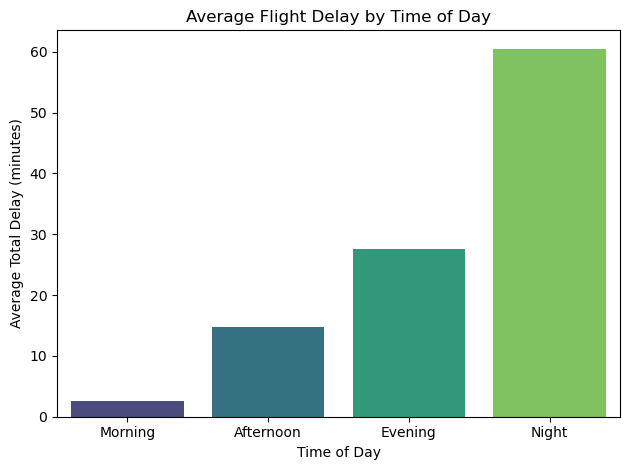

In [9]:
#Bar chart of average delay for each period
sns.barplot(data=avg_delay, x='period', y='totaldelay', palette='viridis')
plt.title('Average Flight Delay by Time of Day')
plt.ylabel('Average Total Delay (minutes)')
plt.xlabel('Time of Day')
plt.tight_layout()
plt.show()

From the bar graph above, it shows that **morning flights** have the **lowest average delays** compared to afternoon, evening or night flights. This is because morning flight is the earlier flights of the day. Hence, there is less possibility of delay if the cre and aircraft are ready early. Meanwhile, night flights have the highest average delays since it is usually the last flight of the day and their performance was depends on the previous flights.

###### b) Which days of the week show better on-time performance? 

In [10]:
#Categorize numbers of day to day names
day_map = {
    1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday',
    5: 'Friday', 6: 'Saturday', 7: 'Sunday'
}

flightdata_new['dayofweek'] = pd.to_numeric(flightdata_new['dayofweek'], errors='coerce')
flightdata_new['dayname'] = flightdata_new['dayofweek'].map(day_map)
flightdata_new.head()

,deptime,arrdelay,depdelay,dayofweek,month,dephour,period,totaldelay,dayname
0,1603,-18.0,-2,5,1,16,Afternoon,-20.0,Friday
1,1559,-23.0,-6,6,1,15,Afternoon,-29.0,Saturday
2,1603,-24.0,-7,7,1,16,Afternoon,-31.0,Sunday
3,1556,-33.0,-9,1,1,15,Afternoon,-42.0,Monday
4,1934,3.0,34,7,1,19,Evening,37.0,Sunday


In [11]:
#Group and calculate average total delay per day
avg_delay_day = (
    flightdata_new.groupby('dayname')['totaldelay']
    .mean()
    .reset_index()
    .sort_values(by='totaldelay')
)

print(avg_delay_day)

     dayname  totaldelay
2   Saturday    9.823640
5    Tuesday   12.213063
3     Sunday   15.100515
6  Wednesday   15.955532
1     Monday   16.978768
4   Thursday   19.818132
0     Friday   20.067686


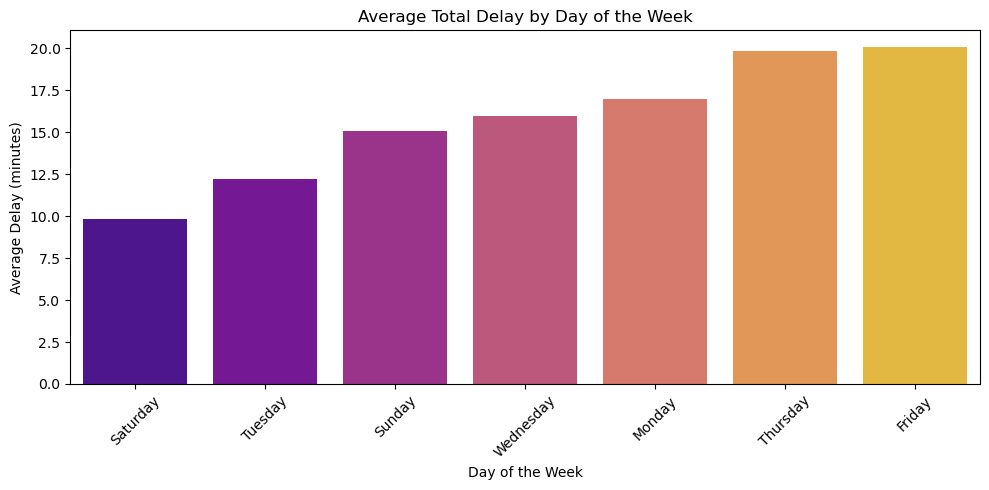

In [12]:
#Bar chart of average delay for each day
plt.figure(figsize=(10, 5))
sns.barplot(data=avg_delay_day, x='dayname', y='totaldelay', palette='plasma')
plt.title('Average Total Delay by Day of the Week')
plt.ylabel('Average Delay (minutes)')
plt.xlabel('Day of the Week')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

From the bar graph above, it shows that Saturday has the lowest average total delay of the week. This means that **Saturday shows better on-time performance** compared to the other days. The second best performance of the week is Tuesday followed Wednesday, Monday, Sunday, Thursday and Friday. Friday shows the highest average delay make it as the worst on-time performance day compared to the other days.

###### c) During which months or seasons are flights most likely to be on time? 

In [13]:
#Change the data type to integer
flightdata_new['month'] = flightdata_new['month'].astype(int)

#Calculate average delay by month
avg_delay_month = flightdata_new.groupby('month')['totaldelay'].mean().reset_index()

#Categorize numbers of month to month names
month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
             7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
avg_delay_month['month'] = avg_delay_month['month'].map(month_map)
avg_delay_month.head()

,month,totaldelay
0,Jan,20.835625
1,Feb,13.861543
2,Mar,16.755430
3,Apr,7.442854
4,May,8.292651


In [14]:
#Sort months in ascending order
avg_delay_month['month'] = pd.Categorical(avg_delay_month['month'],
    categories=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],
    ordered=True)
avg_delay_month = avg_delay_month.sort_values('month')

print(avg_delay_month)

   month  totaldelay
0    Jan   20.835625
1    Feb   13.861543
2    Mar   16.755430
3    Apr    7.442854
4    May    8.292651
5    Jun   20.593783
6    Jul   28.115759
7    Aug   19.118629
8    Sep    7.502069
9    Oct   11.023045
10   Nov   12.251543
11   Dec   23.347142


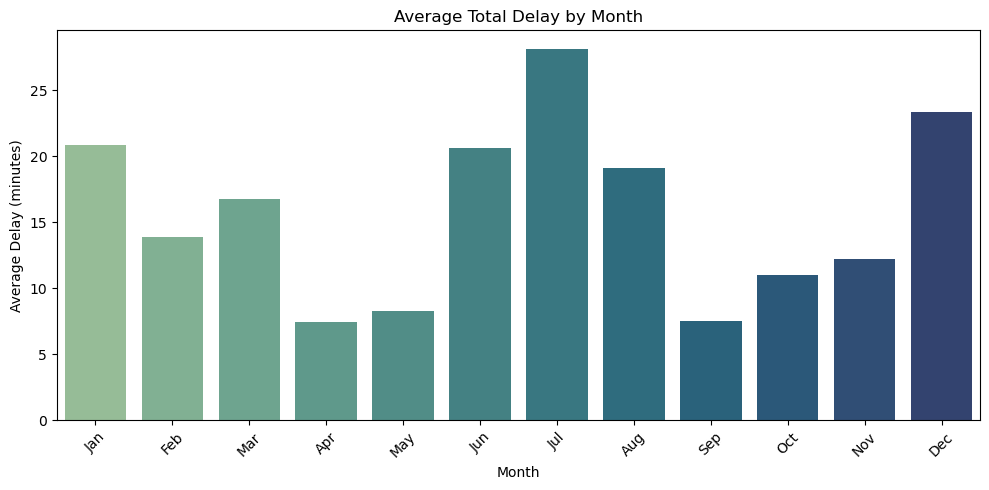

In [15]:
#Bar chart of average delay by month
plt.figure(figsize=(10,5))
sns.barplot(data=avg_delay_month, x='month', y='totaldelay', palette='crest')
plt.title('Average Total Delay by Month')
plt.ylabel('Average Delay (minutes)')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The bar graph above shows the average total delay by month. From the graph, it shows that **November is the months where the flights most likely to be on time** since it has the lowest average total delay with the average of 10.79 minutes compared to the other months. Futhermore, September to November are fall season with milder weather. Hence, the month between September to November are the best on time months with the lowest average delay due to the good weather condition.

##### 2. DELAY FACTORS

###### a) Identify and rank the top 3-5 factors contributing to flight delays, based on the delay categories provided in the dataset. 

In [3]:
#SQL query to read the data in hive
query = 'SELECT carrierdelay, weatherdelay, nasdelay, securitydelay, lateaircraftdelay FROM flight_data_2005' 
flightdata_delay = pd.read_sql(query, conn)
flightdata_delay.head()

,carrierdelay,weatherdelay,nasdelay,securitydelay,lateaircraftdelay
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


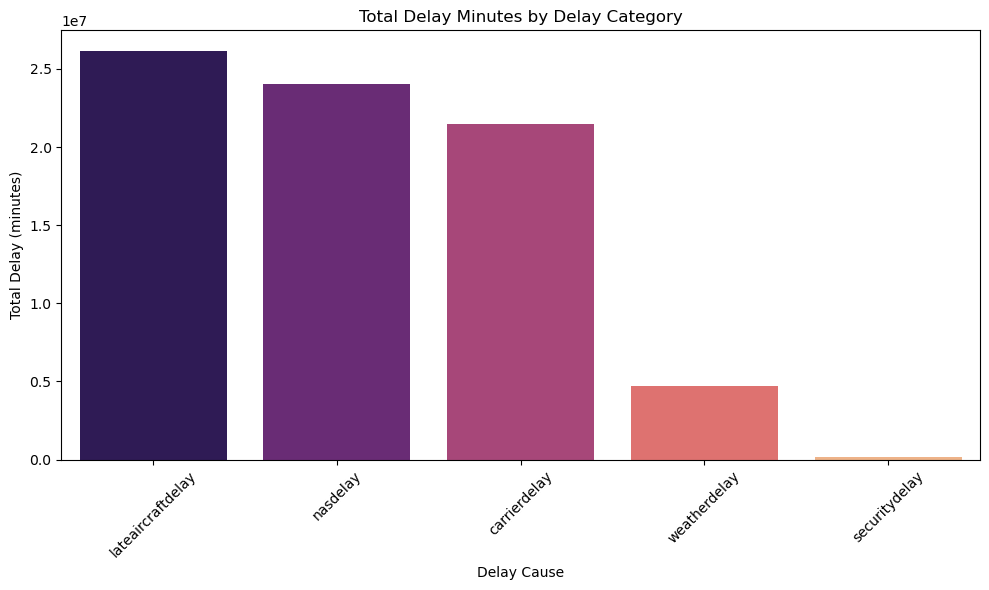

,DelayType,TotalDelayMinutes
0,lateaircraftdelay,26157607
1,nasdelay,24046197
2,carrierdelay,21441880
3,weatherdelay,4713790
4,securitydelay,141045


In [4]:
#Convert delay columns to numeric (handle 'NA' or missing)
delay_columns = ['carrierdelay', 'weatherdelay', 'nasdelay', 'securitydelay', 'lateaircraftdelay']
flightdata_delay[delay_columns] = flightdata_delay[delay_columns].apply(pd.to_numeric, errors='coerce')

#Calculate total delay for each category
total_delays = flightdata_delay[delay_columns].sum().sort_values(ascending=False)

#Convert to DataFrame for display
delay_summary = total_delays.reset_index()
delay_summary.columns = ['DelayType', 'TotalDelayMinutes']

#Plot
plt.figure(figsize=(10,6))
sns.barplot(data=delay_summary, x='DelayType', y='TotalDelayMinutes', palette='magma')
plt.title('Total Delay Minutes by Delay Category')
plt.ylabel('Total Delay (minutes)')
plt.xlabel('Delay Cause')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Display ranked result
delay_summary

From the bar graph above, it shows that late air craft delay was the main factors of the delays. Late air craft delays give about total of 261576 minutes total of total delays. Next, national air system (NAS: traffic control, airport operations, etc.) is the second highest cause of delays with total 240462 minuted in total followed by weather delay and secuirity delay.

###### b) Quantify the impact of each factor (in minutes of delay and percentage of total delays). 

In [5]:
#Grand total delay from all categories
grand_total_delay = total_delays.sum()

#Create summary table
delay_impact = pd.DataFrame({
    'DelayType': total_delays.index,
    'TotalDelayMinutes': total_delays.values,
})
delay_impact['Percentage'] = (delay_impact['TotalDelayMinutes'] / grand_total_delay) * 100

#Sort descending
delay_impact = delay_impact.sort_values(by='TotalDelayMinutes', ascending=False).reset_index(drop=True)

#Format percentage
delay_impact['Percentage'] = delay_impact['Percentage'].round(2)

#Display result
delay_impact

,DelayType,TotalDelayMinutes,Percentage
0,lateaircraftdelay,26157607,34.19
1,nasdelay,24046197,31.43
2,carrierdelay,21441880,28.03
3,weatherdelay,4713790,6.16
4,securitydelay,141045,0.18


From the output generated above, it shows that Late air craft delays contributes the highest factor of delays with 34.19 per cent. NAS delay is the second highest at 31.43 per cent followed by carrier delay at 28.03 per cent and weather delay at 6.16 per cent. Security delays contribute very little with 0.18 of all the percentage delay.

##### 3. CANCELLATION ANALYSIS

###### a) Identify the primary reasons for flight cancellations as categorized in the dataset. 

In [4]:
#SQL query to read the data in hive
query = 'SELECT cancelled, cancellationcode, uniquecarrier, origin FROM flight_data_2005' 
flightdata_cancel = pd.read_sql(query, conn)
flightdata_cancel.head()

,cancelled,cancellationcode,uniquecarrier,origin
0,0,,UA,BOS
1,0,,UA,BOS
2,0,,UA,BOS
3,0,,UA,BOS
4,0,,UA,ORD


In [5]:
#Filter only cancelled flights
cancelled_flights = flightdata_cancel[flightdata_cancel['cancelled'] == '1']

#Count cancellation reasons
cancellation_reasons = cancelled_flights['cancellationcode'].value_counts().reset_index()
cancellation_reasons.columns = ['CancellationCode', 'Count']

#Map codes to full reason
code_map = {'A': 'Carrier', 'B': 'Weather', 'C': 'NAS', 'D': 'Security'}
cancellation_reasons['Reason'] = cancellation_reasons['CancellationCode'].map(code_map)

cancellation_reasons

,CancellationCode,Count,Reason
0,A,59350,Carrier
1,B,51204,Weather
2,C,23084,NAS
3,D,92,Security


Cancellation code A been labeled as flight cancellation due to the carrier, B for weather, C for NAS and D for secuirity. Cancellation code A has the highest number of cancellation which means most of the flights are cancelled because of the carrier issue. Next was weather issue followed by NAS and security.

###### b) Determine if cancellations correlate with specific airlines, airports, or time periods.

In [6]:
#Count cancellations by airline
cancellations_by_airline = flightdata_cancel[flightdata_cancel['cancelled'] == '1'].groupby('uniquecarrier').size().reset_index(name='cancel_count')

#Sort descending
cancellations_by_airline = cancellations_by_airline.sort_values(by='cancel_count', ascending=False)
cancellations_by_airline

,uniquecarrier,cancel_count
5,DL,17731
11,MQ,16746
6,EV,13900
13,OH,11370
0,AA,9752
14,OO,9639
19,XE,9353
18,WN,8759
17,US,8426
12,NW,6937


The results shows the cancellation by each airline. The DL airline contribues the highest cancellation counts followed by MQ, EV, OH, AA and OO

In [8]:
# Count cancellations by airport of origin
cancellations_by_airport = flightdata_cancel[flightdata_cancel['cancelled'] == '1'].groupby('origin').size().reset_index(name='cancel_count')
cancellations_by_airport = cancellations_by_airport.sort_values(by='cancel_count', ascending=False)
cancellations_by_airport

,origin,cancel_count
17,ATL,13837
199,ORD,8466
154,LGA,5063
90,EWR,4622
69,CVG,4606
...,...,...
134,IPL,2
161,LWB,1
219,PVU,1
210,PIE,1


The flight from ATL shows that highest flight cancellation count based on the airports origin. From the results, it shows that flight from ATL with 13837 number of cancellations. The second highest aiports that give highest number of cancellation was ORD, LGA, EWR, CVG and others. This analysis can help to identify issue that are happened with the origin country that have the highest number of cancellations. 

##### 4. PROBLEMATIC ROUTES

In [13]:
#SQL query to read the data in hive
query = 'SELECT origin, dest, uniquecarrier, flightnum, arrdelay, depdelay, cancelled, cancellationcode, carrierdelay, weatherdelay, nasdelay, securitydelay, lateaircraftdelay FROM flight_data_2005' 
flightdata_routes = pd.read_sql(query, conn)
flightdata_routes.head()

,origin,dest,uniquecarrier,flightnum,arrdelay,depdelay,cancelled,cancellationcode,carrierdelay,weatherdelay,nasdelay,securitydelay,lateaircraftdelay
0,BOS,ORD,UA,541,-18,-2,0,,0,0,0,0,0
1,BOS,ORD,UA,541,-23,-6,0,,0,0,0,0,0
2,BOS,ORD,UA,541,-24,-7,0,,0,0,0,0,0
3,BOS,ORD,UA,541,-33,-9,0,,0,0,0,0,0
4,ORD,BOS,UA,542,3,34,0,,0,0,0,0,0


In [17]:
#Replace 'NA' or empty with 0.0 for delay columns
delay_cols = ['arrdelay', 'depdelay', 'carrierdelay', 'weatherdelay', 'nasdelay', 'securitydelay', 'lateaircraftdelay']

for col in delay_cols:
    flightdata_routes[col] = pd.to_numeric(flightdata_routes[col], errors='coerce')

#Fill NaN delays with 0 (optional)
#flightdata_routes[delay_cols] = flightdata_routes[delay_cols].fillna(0)

#Convert cancelled column to integer
flightdata_routes['cancelled'] = flightdata_routes['cancelled'].astype(int)

#Create a total delay column (arrival + departure)
flightdata_routes['totaldelay'] = flightdata_routes['arrdelay'] + flightdata_routes['depdelay']
flightdata_routes.head()

,origin,dest,uniquecarrier,flightnum,arrdelay,depdelay,cancelled,cancellationcode,carrierdelay,weatherdelay,nasdelay,securitydelay,lateaircraftdelay,totaldelay
0,BOS,ORD,UA,541,-18.0,-2.0,0,,0.0,0.0,0.0,0.0,0.0,-20.0
1,BOS,ORD,UA,541,-23.0,-6.0,0,,0.0,0.0,0.0,0.0,0.0,-29.0
2,BOS,ORD,UA,541,-24.0,-7.0,0,,0.0,0.0,0.0,0.0,0.0,-31.0
3,BOS,ORD,UA,541,-33.0,-9.0,0,,0.0,0.0,0.0,0.0,0.0,-42.0
4,ORD,BOS,UA,542,3.0,34.0,0,,0.0,0.0,0.0,0.0,0.0,37.0


###### a) Identify specific routes (origin-destination pairs), carriers, or flight numbers that show consistently poor performance.

###### - specific routes (origin-destination pairs)


In [20]:
avg_delay_by_route = flightdata_routes.groupby(['origin', 'dest'])['totaldelay'].mean().reset_index()
avg_delay_by_route = avg_delay_by_route.sort_values(by='totaldelay', ascending=False)
avg_delay_by_route.head()

,origin,dest,totaldelay
3705,PIT,AVP,692.000000
2646,LNK,COS,511.000000
3323,ONT,PSP,431.333333
1883,HLN,BIL,399.000000
55,ACV,RDD,381.000000


The output shows the top 5 specific flight routes (origin-destination pairs) that show consistently high number delays. The results show that the flight origin from PIT to AVP have the highest total numbers of delays indicate the poor performance. The second highest number of delays are the flights from LNK to COS, followed by ONT to PSP, HLN to BIL and ACV to RDD. This five route need further attention and action on the route and identify the main causes of the delay to fix this issue.

###### - carriers

In [22]:
avg_delay_by_carrier = flightdata_routes.groupby('uniquecarrier')['totaldelay'].mean().reset_index()
avg_delay_by_carrier = avg_delay_by_carrier.sort_values(by='totaldelay', ascending=False)
avg_delay_by_carrier.head()

,uniquecarrier,totaldelay
8,FL,29.179501
1,AS,25.305743
6,EV,22.075898
2,B6,20.939982
0,AA,17.534868


The results below show the top 5 carriers with the highest average delay. The FL carriers has the highest average delay per flight awith 29.18 minutes total delays. This followed by AS with 25.31 minutes, EV with 22.08 minutes, B6 with 20.94 and AA with 17.53 minutes. This carriers need further investigation on the main cause of the delay to fix this issue.

###### - flight numbers

In [24]:
avg_delay_by_flight = flightdata_routes.groupby('flightnum')['totaldelay'].mean().reset_index()
avg_delay_by_flight = avg_delay_by_flight.sort_values(by='totaldelay', ascending=False)
avg_delay_by_flight.head()

,flightnum,totaldelay
6250,6744,444.000000
5477,6012,335.500000
4441,5001,238.500000
5879,6399,186.800000
6030,6537,136.117647


This analysis identifies the flight numbers with the highest average total delay. The flight 6744 has the worst performance with the highest total delay about 444 minutes. Flights 6012 and 5001 also show consistently high delays with 335 and 238 minutes accordingly. Flight 6399 and 6537 also considered as significantly high with 186 and 136 minutes.

###### b) Analyse the reasons these particular flights are prone to delays or cancellations

In [27]:
reason_cols = ['carrierdelay', 'weatherdelay', 'nasdelay', 'securitydelay', 'lateaircraftdelay']

# Average delay reasons per flight
avg_reason_by_flight = flightdata_routes.groupby('flightnum')[reason_cols].mean().reset_index()

# Combine with avg total delay
problematic_flights = pd.merge(avg_delay_by_flight, avg_reason_by_flight, on='flightnum')
problematic_flights = problematic_flights.sort_values(by='totaldelay', ascending=False)
problematic_flights.head()

,flightnum,totaldelay,carrierdelay,weatherdelay,nasdelay,securitydelay,lateaircraftdelay
0,6744,444.000000,0.000000,160.0,0.0,0.0,0.000000
1,6012,335.500000,13.500000,0.0,162.0,0.0,0.000000
2,5001,238.500000,77.500000,34.5,11.5,0.0,0.000000
3,6399,186.800000,3.200000,0.0,25.4,0.0,65.800000
4,6537,136.117647,55.882353,0.0,0.0,0.0,10.764706


This results investigates the main reasons behind the high average delays for the top 5 most delayed flights. The types of delay are carrier delay, weather delay, NAS delay, security delay and late air craft delay. For the flight number 6744 with the highest delay of 444 minutes are because of the weather. Flight 6012 was delayed because of NAS delay and some of carrier delay. Next, flight 5011 and 6399 was delayed because of carrier and NAS delay accordingly. Flight number 6537 was delayed because of carrier. Strategy can be implemented based on this analysis to ensure that the flight can be on-time and increase their performance.